# Experiment Lecture 03 : Introduction Fully connected model and Dataloader

Deep Learning, RT5101, 2021, Spring, (Tue/Thurs 2:30~3:45)
***

## Syllabus
- This course is for students who do not have prior knowledge of deep learning. It covers basic math tools, artificial neural network, multilayered perceptrons, backpropagation, deep convolutional neural network. The algorithms are applied to linear regression and image classification.
- Textbook: Deep Learning Book by Ian Goodfellow, Yoshua Bengio and Aaron Courville


## Teaching Staff
- Professor: Kyoobin Lee (kyoobinlee@gist.ac.kr)
- TA: Seongju Lee (lsj2121@gm.gist.ac.kr)
- TA: Seongho Bak (bakseongho@gist.ac.kr)
- TA: Jongwon Kim (jongwonkim@gm.gist.ac.kr)
- TA: Taewon Kim (ailab.ktw@gm.gist.ac.kr)
- TA: Junseok Lee (junseoklee@gm.gist.ac.kr)
- TA: Changhyun Jun (junch9634@gm.gist.ac.kr)

## Model define

In [15]:
import torch
import torch.nn as nn

class SimpleFCN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFCN, self).__init__()

        self.fc1 = nn.Linear(in_features=784, out_features=128)

        self.fc2 = nn.Linear(in_features=128, out_features=64)

        self.out_fc = nn.Linear(in_features=64, out_features=num_classes)

        self.relu = nn.ReLU(inplace=True)

        
    def forward(self, x):

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        output = self.out_fc(x)
        return output


        

## Dataset define

In [2]:
from torchvision import datasets, transforms

def mnist_dataset(is_train):

    if is_train:
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    else:
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    dataset = datasets.MNIST(root='./data',train=is_train,
                    download=True,transform=transform)

    return dataset

In [ ]:
import numpy as np
from PIL import Image
import glob

import torch
from torch.utils.data.dataset import Dataset


class CustomDatasetFromFile(Dataset):
    def __init__(self, folder_path, transformer):
    
        self.image_list = glob.glob(folder_path+'*')

        self.data_len = len(self.image_list)

        self.transformer = transformer

    def __getitem__(self, index):

        single_image_path = self.image_list[index]

        img = Image.open(single_image_path)

        img = self.transformer(img)
 
        img_as_ten = torch.from_numpy(img).float()

        class_indicator_location = single_image_path.rfind('_c')

        label = int(single_image_path[class_indicator_location+2:class_indicator_location+3])

        return (img_as_ten, label)

    def __len__(self):
        return self.data_len



## Model train

In [8]:
import matplotlib.pyplot as plt

def result_plot(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']

    plt.clf() 
    plt.figure(figsize=(15, 5))

    epochs = range(1, len(acc) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

In [3]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
GPU_NUM = 0
lr = 1e-4
batch_size = 64
epochs = 20

device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')


train_dataset = mnist_dataset(is_train=True)
val_dataset = mnist_dataset(is_train=False)


train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)
                                                        
val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)


model = SimpleFCN(num_classes=10).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss().to(device)



In [17]:
train_loss_arr = []
train_acc_arr = []

val_loss_arr = []
val_acc_arr = []


for epoch in range(epochs):

    model.train()

    losses = AverageMeter()
    top1 = AverageMeter()

    for i, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        output = model(data) 

        loss = criterion(output, target)

        output.float()
        loss.float()

        prec1 = accuracy(output.data, target)
        prec1 = prec1[0]

        losses.update(loss.item(), data.size(0))
        top1.update(prec1.item(), data.size(0))

        if i % 100 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, len(train_loader), loss=losses))

        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss_arr.append(losses.avg)
    train_acc_arr.append(top1.avg)
    print("train result: Loss: {}, Acc: {}\n".format(losses.avg, top1.avg))


    model.eval()
    with torch.no_grad():
        val_loss_sum = 0
        val_acc_sum = 0

        losses = AverageMeter()
        top1 = AverageMeter()

        for i, (data, target) in enumerate(val_loader):
            data = data.to(device)
            target = target.to(device)

            output = model(data) 

            loss = criterion(output, target)

            output.float()
            loss.float()

            prec1 = accuracy(output.data, target)

            prec1 = prec1[0]
            losses.update(loss.item(), data.size(0))
            top1.update(prec1.item(), data.size(0))

            if i % 100 == 0:
                print('Test: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), loss=losses, top1=top1))

        val_loss_arr.append(losses.avg)
        val_acc_arr.append(top1.avg)
        print("Validation result: Loss: {}, Acc: {}\n".format(losses.avg, top1.avg))


Epoch: [0][0/938]	Loss 2.2921 (2.2921)
Epoch: [0][100/938]	Loss 2.3162 (2.2963)
Epoch: [0][200/938]	Loss 2.2933 (2.2876)
Epoch: [0][300/938]	Loss 2.2448 (2.2771)
Epoch: [0][400/938]	Loss 2.2382 (2.2658)
Epoch: [0][500/938]	Loss 2.1878 (2.2537)
Epoch: [0][600/938]	Loss 2.1722 (2.2410)
Epoch: [0][700/938]	Loss 2.1619 (2.2272)
Epoch: [0][800/938]	Loss 2.1141 (2.2119)
Epoch: [0][900/938]	Loss 2.0328 (2.1953)
train result: Loss: 2.1887093894958496, Acc: 32.64666666666667

Test: [0/157]	Loss 2.0017 (2.0017)	Prec@1 57.812 (57.812)
Test: [100/157]	Loss 1.9880 (2.0239)	Prec@1 45.312 (54.022)
Validation result: Loss: 2.0108868436813356, Acc: 56.41

Epoch: [1][0/938]	Loss 2.0479 (2.0479)
Epoch: [1][100/938]	Loss 1.9624 (1.9895)
Epoch: [1][200/938]	Loss 1.9301 (1.9606)
Epoch: [1][300/938]	Loss 1.8205 (1.9295)
Epoch: [1][400/938]	Loss 1.7574 (1.8983)
Epoch: [1][500/938]	Loss 1.7081 (1.8639)
Epoch: [1][600/938]	Loss 1.5358 (1.8282)
Epoch: [1][700/938]	Loss 1.5046 (1.7883)
Epoch: [1][800/938]	Loss 1.

<Figure size 432x288 with 0 Axes>

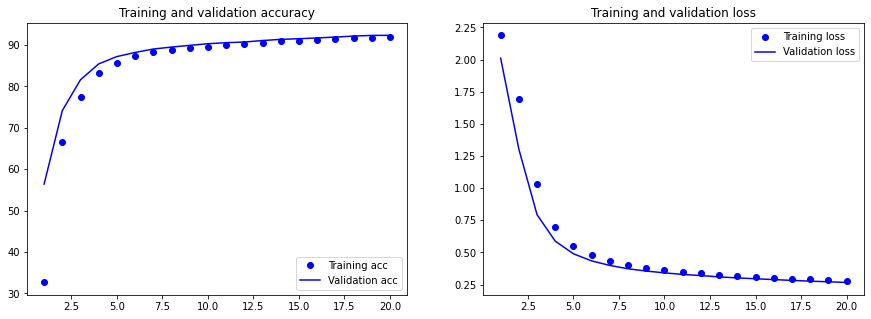

In [18]:
history = {}

history['acc'] = train_acc_arr
history['loss'] = train_loss_arr

history['val_acc'] = val_acc_arr 
history['val_loss'] = val_loss_arr

result_plot(history)